# Section 1 - Problem Understanding

# Section 1.1 Dataset Selection

**Link:** https://www.kaggle.com/datasets/rishabjadhav/nfl-rushing-statistics-2001-2023

**Description:** My dataset contains NFL rushing statistics for every player from 2001 up to 2023.

**Fields**:

**Player:** The name of the NFL player

**Age:** The age of the NFL player for that season

**G:** The amount of games the player had playing time in that season

**GS:** The amount of games the player started in that season

**rAtt:** The amount of rushing attenmpts the player had for that season

**rYds:** The amount of rushing yards the player had for that season

**rTD:** The amount of rushing touchdowns the player had for that season

**r1D:** The amount of rushing first downs the player had for that season

**rLng:** The longest run the player had for that season

**rY/A:** The average yards per rushing attempt the player had for that season

**rY/G:** The average rushing yards per game the player had for that season

**Fmb:** The total amount of fumbles the player had for that season

**Year:** The year the season took place

# Section 1.2 Defining a Classification Task

**Task 2:** Divide players into two categories. Players who fumble more than 4 times have a value of 1. Players who fumble less than 4 times have a value of 0.

#Section 1.3 Defining a Prediction Task

**Task 3:** Predict a players rushing touchdowns based on their rushing stats and age.

In [ ]:
#Step 2. DATA PREPARATION

# 2.1. Load the dataset

# 2.1.1 Load required libraries
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.pipeline import Pipeline

#2.1.2 Load the dataset
drive.mount('/content/drive')
data = "/content/drive/My Drive/rushing_cleaned.csv"
rushingData = pd.read_csv(data,sep=',')

# Show the first few rows of the DataFrame
rushingData.head()

Mounted at /content/drive


,Unnamed: 0,Player,Age,G,GS,rAtt,rYds,rTD,r1D,rLng,rY/A,rY/g,Fmb,Year
0,0,Stephen Davis,27,16,16,356,1432,5,75,32,4.0,89.5,6,2001
1,1,Corey Dillon,27,16,16,340,1315,10,69,96,3.9,82.2,5,2001
2,2,LaDainian Tomlinson,22,16,16,339,1236,10,68,54,3.6,77.3,8,2001
3,3,Curtis Martin,28,16,16,333,1513,10,78,47,4.5,94.6,2,2001
4,4,Priest Holmes,28,16,16,327,1555,8,81,41,4.8,97.2,4,2001


In [ ]:
rushingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7516 entries, 0 to 7515
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7516 non-null   int64  
 1   Player      7516 non-null   object 
 2   Age         7516 non-null   int64  
 3   G           7516 non-null   int64  
 4   GS          7516 non-null   int64  
 5   rAtt        7516 non-null   int64  
 6   rYds        7516 non-null   int64  
 7   rTD         7516 non-null   int64  
 8   r1D         7516 non-null   int64  
 9   rLng        7516 non-null   int64  
 10  rY/A        7516 non-null   float64
 11  rY/g        7516 non-null   float64
 12  Fmb         7516 non-null   int64  
 13  Year        7516 non-null   int64  
dtypes: float64(2), int64(11), object(1)
memory usage: 822.2+ KB


In [ ]:
# 2.2. Handling missing data.
rushingData = rushingData.dropna()

# Creating features or encoding categorical values.
# Applying feature scaling or normalization.

#Im filtering my data to only include players who had at least 120
#carries for a season. This is to filter out players who do not
#play a significant role

lenData = len(rushingData)
print("Number of entries in the dataset:", lenData)

rushingData = rushingData[rushingData['rAtt'] >= 120]

lenData = len(rushingData)
print("Number of entries in the dataset:", lenData)


#Players who fumble more than 3 times have a value of 1
#players who fumble less than 3 times have a value of 0

rushingData['Fumble pred'] = np.where(rushingData['Fmb'] <= 3, 0, 1)

print(rushingData.head())


Number of entries in the dataset: 7516
Number of entries in the dataset: 924
   Unnamed: 0               Player  Age   G  GS  rAtt  rYds  rTD  r1D  rLng  \
0           0        Stephen Davis   27  16  16   356  1432    5   75    32   
1           1         Corey Dillon   27  16  16   340  1315   10   69    96   
2           2  LaDainian Tomlinson   22  16  16   339  1236   10   68    54   
3           3        Curtis Martin   28  16  16   333  1513   10   78    47   
4           4        Priest Holmes   28  16  16   327  1555    8   81    41   

   rY/A  rY/g  Fmb  Year  Fumble pred  
0   4.0  89.5    6  2001            1  
1   3.9  82.2    5  2001            1  
2   3.6  77.3    8  2001            1  
3   4.5  94.6    2  2001            0  
4   4.8  97.2    4  2001            1  


<ipython-input-3-5da71fdb1618>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rushingData['Fumble pred'] = np.where(rushingData['Fmb'] <= 3, 0, 1)


In [ ]:
#Step 3. EXPLORATORY DATA ANALYSIS

#3.1 Analyzing basic trend statistics, generating box plots, scatter plots, among others.

#3.1.1. Trend statistics
rushingData.describe()

,Unnamed: 0,Age,G,GS,rAtt,rYds,rTD,r1D,rLng,rY/A,rY/g,Fmb,Year,Fumble pred
count,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000
mean,3625.812771,25.816017,14.610390,10.994589,211.346320,905.334416,6.472944,45.939394,47.600649,4.274567,62.211905,2.645022,2011.984848,0.280303
std,2220.988057,2.890700,1.924845,4.573580,63.940174,314.526750,4.029459,16.843638,18.549504,0.664119,19.892318,2.165815,6.702128,0.449390
min,0.000000,21.000000,6.000000,0.000000,120.000000,370.000000,0.000000,0.000000,12.000000,2.700000,24.900000,0.000000,2001.000000,0.000000
25%,1671.750000,24.000000,14.000000,8.000000,157.000000,660.000000,3.000000,33.000000,33.000000,3.800000,46.900000,1.000000,2006.000000,0.000000
50%,3602.500000,25.000000,15.000000,12.000000,202.500000,849.000000,6.000000,44.000000,45.000000,4.200000,60.100000,2.000000,2012.000000,0.000000
75%,5556.250000,28.000000,16.000000,15.000000,255.000000,1098.250000,9.000000,55.000000,60.250000,4.600000,75.525000,4.000000,2018.000000,1.000000
max,7421.000000,37.000000,17.000000,17.000000,416.000000,2097.000000,28.000000,109.000000,99.000000,8.400000,131.100000,16.000000,2023.000000,1.000000


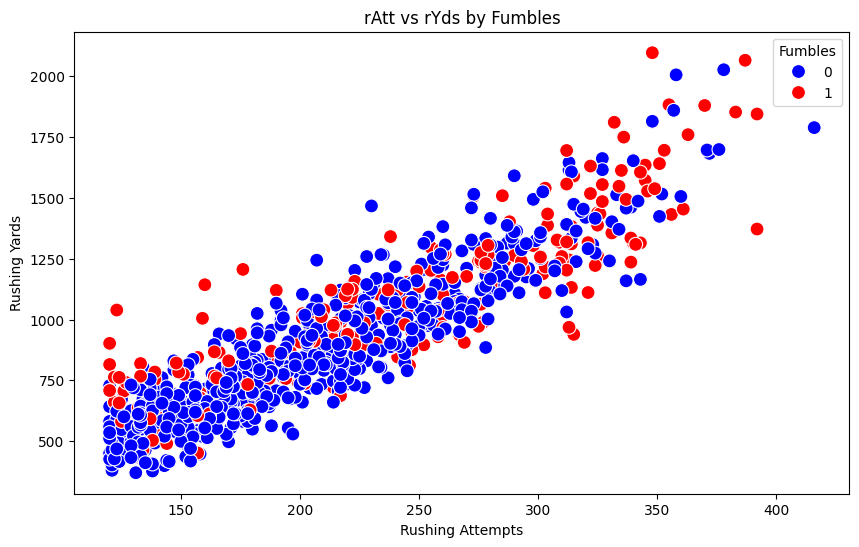

In [ ]:
plt.figure(figsize=(10, 6))
palette = {0: 'blue', 1: 'red'}
sns.scatterplot(x='rAtt', y='rYds', hue='Fumble pred', data=rushingData, palette=palette, s=100)
plt.title('rAtt vs rYds by Fumbles')
plt.xlabel('Rushing Attempts')
plt.ylabel('Rushing Yards')
plt.legend(title='Fumbles')
plt.show()

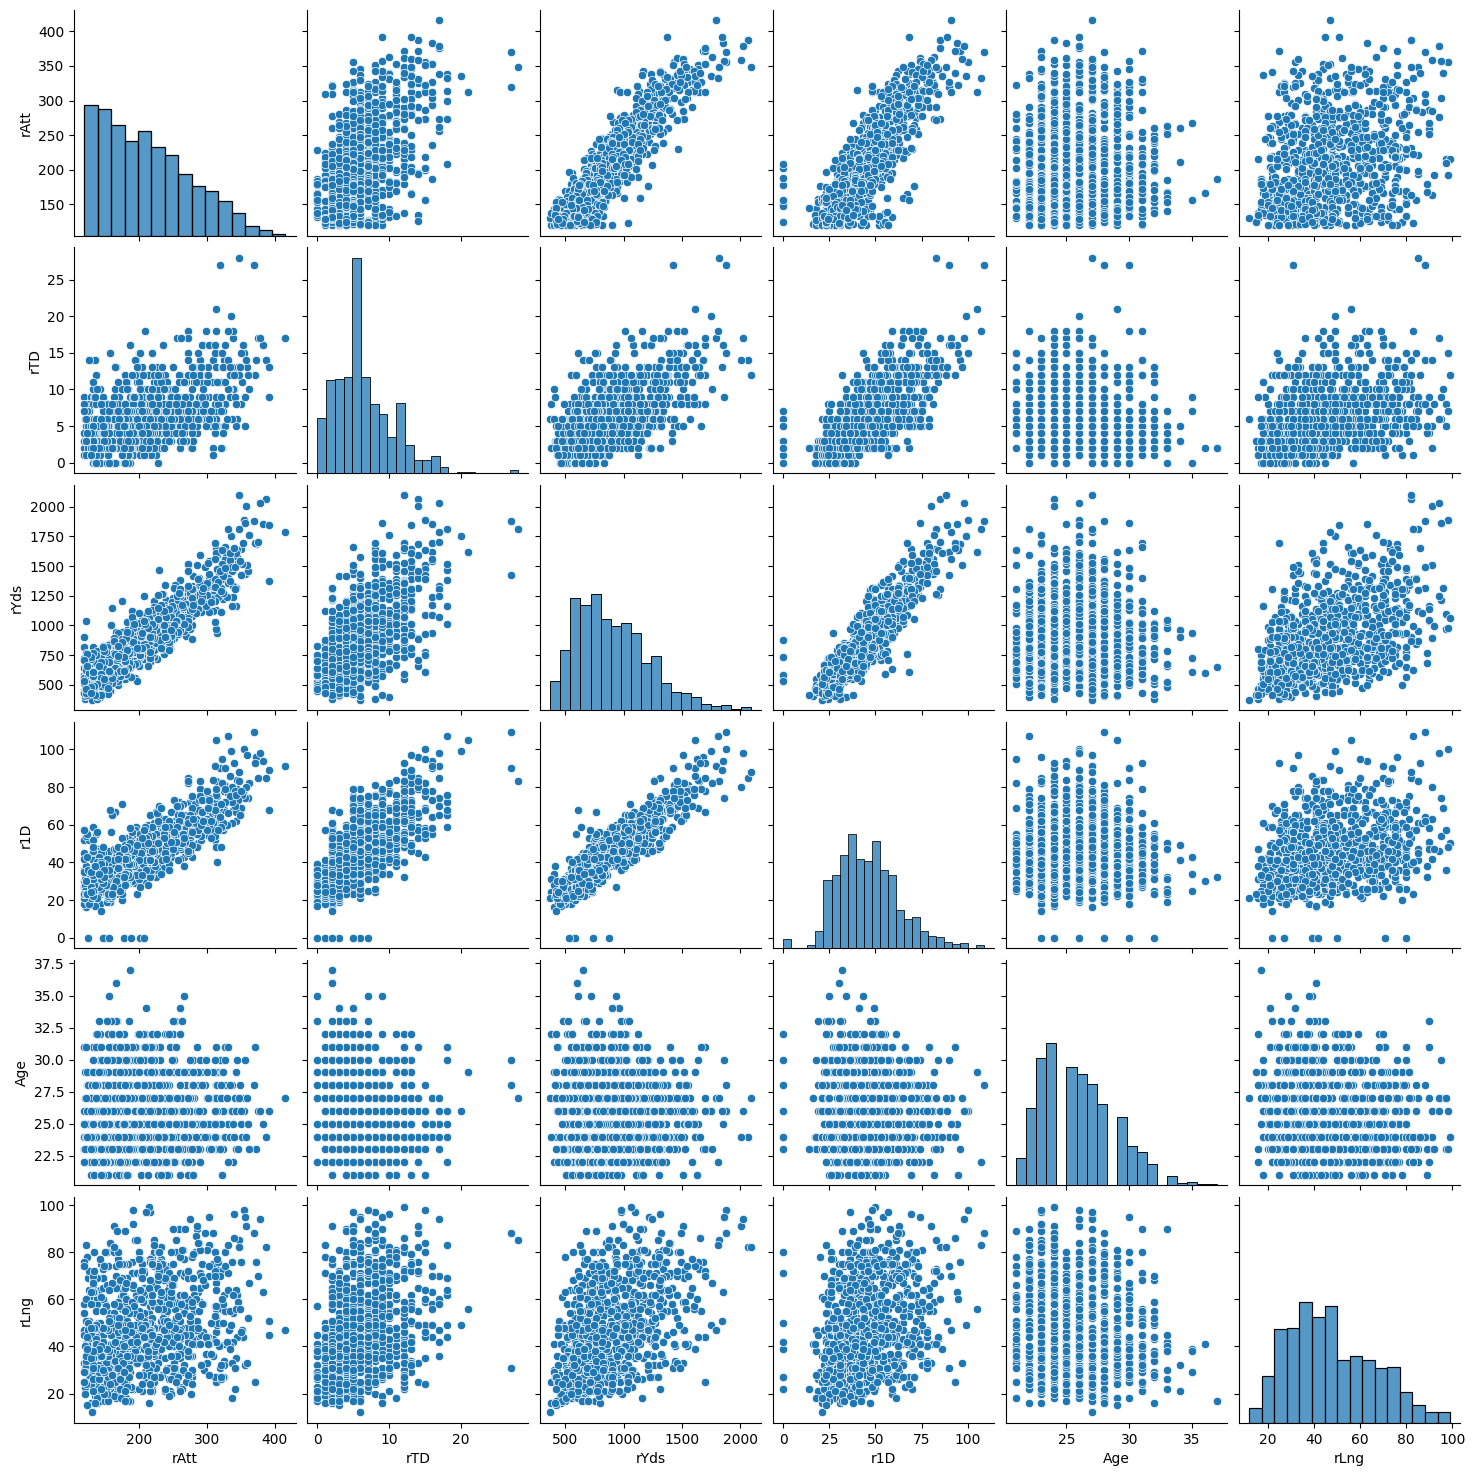

In [ ]:
# Create a scatter plot matrix
sns.pairplot(rushingData[['rAtt','rTD','rYds','r1D', 'Age', 'rLng']], diag_kind='hist')
plt.show()

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i)
                       for i in range(dataframe.shape[1])]
    return vif_data

df_features = rushingData.drop(columns=['Fumble pred','Player'])
print(calculate_vif(df_features))

       Feature          VIF
0   Unnamed: 0     4.704695
1          Age    89.703954
2            G   794.669688
3           GS    14.251532
4         rAtt   640.174024
5         rYds  1052.123846
6          rTD     7.706726
7          r1D    62.107669
8         rLng    12.464562
9         rY/A   483.540831
10        rY/g   712.318334
11         Fmb     3.273842
12        Year  1200.135500


# Analysis

**VIF:** The varaibles with the most multicollinearity were Games, Rushing Attempts, Rushing yards, Rushing Yards per Attempt, Rushing Yards per Game, and Year. This shows that these values correlate highly with others in my data set. The variables with the lowest multicollinearity are Rushing Touchdowns and Fumbles. This shows that they are much more independent from other variables in the dataset. This also supports my choice to use Fumbles for classification and Rushing Touchdowns for prediction.

In [ ]:
#Step 4. SETUP PHASE
#4.1. Preparing the Python environment, importing libraries. - Done in 2.2.1.
#4.2. Setting up your X (features) and Y (target) data. - Done in 2.1.2.
#4.3. Split the dataset into training and testing sets for validation (Done before each Model)

In [ ]:
#Step 5. MODELING PHASE
#Apply several models:
#5.1.	Multiple Logistic Regression(Task 1)
#5.2.	Random Forest Classifier(Task 1)
#5.3.	Polynomial Regression(Task 2)
#5.4.	Decision Tree for regression(Task 2)

In [ ]:
#5.1.	Multiple Logistic Regression (TASK 1)

#5.1.2. Selecting a subset of the features
X = rushingData[['rAtt', 'r1D', 'rYds', 'rLng', 'Age']]
X = sm.add_constant(X)  # Adds a constant column to input features to account for the intercept
y = rushingData['Fumble pred']

#5.1.3. Split the dataset in training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#5.1.4. Fit a logistic regresion model
model = sm.Logit(y_train, X_train).fit()

#5.1.5. Display model summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.559882
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            Fumble pred   No. Observations:                  739
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            5
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                 0.05796
Time:                        15:45:30   Log-Likelihood:                -413.75
converged:                       True   LL-Null:                       -439.21
Covariance Type:            nonrobust   LLR p-value:                 9.014e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5421      0.882     -0.614      0.539      -2.271       1.187
rAtt          -0.0003      0.003     -0.093      0.926      -0.007       0.006
r1D            0.0150      0.012      1.275      0.202      -0.008       0.038
rYds           0.0010      0.001      1.088      0.277      -0.001       0.003
rLng          -0.0006      0.006     -0.099      0.921      -0.012       0.011
Age           -0.0774      0.032     -2.438      0.015      -0.140      -0.015
==============================================================================
"""

In [ ]:
#5.1.6. Predicting probabilities
y_pred_prob = model.predict(X_test)

#5.1.7. Convert probabilities to binary predictions based on a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

#5.1.8. Predicting and evaluating the model
print(classification_report(y_test.values, y_pred.values))

              precision    recall  f1-score   support

           0       0.75      0.99      0.86       134
           1       0.88      0.14      0.24        51

    accuracy                           0.76       185
   macro avg       0.81      0.56      0.55       185
weighted avg       0.79      0.76      0.68       185



# Analysis

This model has a low pseudo R^2 of only 0.058. This indicates that this model might not be the best fit for my data. But on my classification report my model actually preformed much better. The precision is actually high for both 0 and 1. But the recall for more than 3 fumvles is very low. The f1 score is also very low for this.

Accuracy: 0.7621621621621621
              precision    recall  f1-score   support

           0       0.77      0.96      0.85       134
           1       0.68      0.25      0.37        51

    accuracy                           0.76       185
   macro avg       0.73      0.61      0.61       185
weighted avg       0.75      0.76      0.72       185



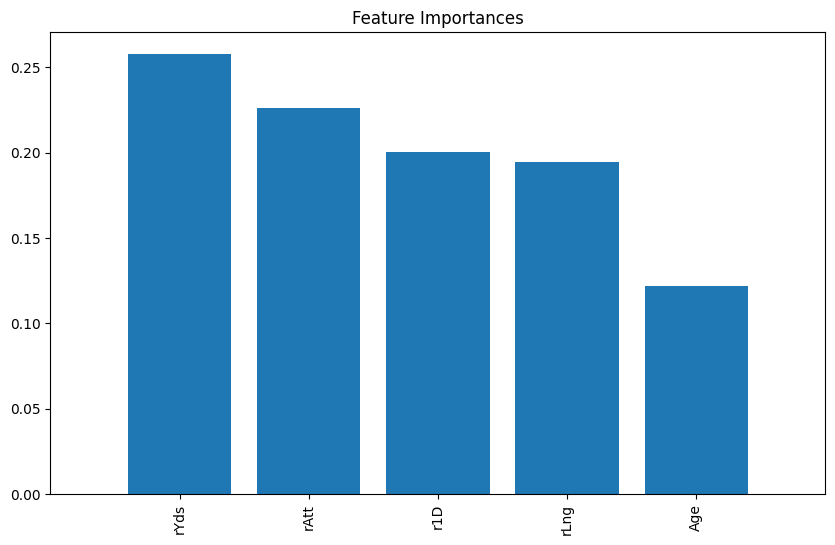

In [ ]:
#5.2.	Random Forest Classifier (TASK 1)

#5.2.1. Selecting a subset of the features
X = rushingData[['rAtt', 'r1D', 'rYds', 'rLng', 'Age']]
#X = sm.add_constant(X)  # Adds a constant column to input features to account for the intercept
y = rushingData['Fumble pred']

#5.2.2. Split the dataset in training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#5.2.3. Creating a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

#5.2.4. Training the model
clf.fit(X_train, y_train)

#5.2.5. Making predictions
y_pred = clf.predict(X_test)

#5.2.6. Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#5.2.7. Print detailed classification metrics
print(classification_report(y_test, y_pred))

#5.2.8. Feature importances
# Used to retrieve the importance of each feature in the dataset.
# It gives you a score for each feature, the higher the score, the more relevant.
# Measures how much each feature contributes to decreasing the weighted impurity in a tree
# or in other words how much the model's predictions depend on this feature.
feature_importances = clf.feature_importances_
features = ['rAtt', 'r1D', 'rYds', 'rLng', 'Age']
indices = np.argsort(feature_importances)[::-1]

#5.2.9. Plotting Feature Importances
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Analysis

Similiar to the Multiple Logistic Regression model preforming well with predicitng less than 3 fumbles. But the model did poorly predicitng more than 3 fumbles. When predicting this the model has a very low recall and f1 score. The most important feature for this was interestingly rushing yards. The model only had an accuracy of 76%. This suggests that there are possibly more under lying variabless that go into a player fumbling.

In [ ]:
# Select predictor variables (x) and target variable (y)
X = rushingData[['rAtt', 'r1D', 'rYds', 'rLng', 'Age']]
X = sm.add_constant(X)  # Adds a constant column to input features to account for the intercept
y = rushingData['rTD']

# Split the dataset into training and testing sets for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#5.3.	Polynomial Regression (Task 2)

# 5.3.1. Using a pipeline for 3rd-degree polynomial regression
poly3_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the features
    ('poly', PolynomialFeatures(degree=3)),  # Then, generate polynomial features
    ('linear', LinearRegression())  # Finally, apply linear regression
])

# 5.3.2. Fit the pipeline on the training data
poly3_pipeline.fit(X_train, y_train)

# 5.3.3. Predict on the test data
y_pred_poly3 = poly3_pipeline.predict(X_test)

# 5.3.4. Calculate MSE
mse_poly3 = mean_squared_error(y_test, y_pred_poly3)

# 5.3.5. Print the MSE for the 3rd-degree polynomial model
print(f"Mean Squared Error for 3rd-degree Polynomial: {mse_poly3:.2f}")

# 5.3.6. Using a pipeline for 4th-degree polynomial regression
poly4_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the features
    ('poly', PolynomialFeatures(degree=4)),  # Then, generate polynomial features
    ('linear', LinearRegression())  # Finally, apply linear regression
])

# 5.3.7. Fit the pipeline on the training data
poly4_pipeline.fit(X_train, y_train)

# 5.3.8. Predict on the test data
y_pred_poly4 = poly4_pipeline.predict(X_test)

# 5.3.9. Calculate MSE
mse_poly4 = mean_squared_error(y_test, y_pred_poly4)

# 5.3.10. Print the MSE for the 4th-degree polynomial model
print(f"Mean Squared Error for 4th-degree Polynomial: {mse_poly4:.2f}")

# 5.3.11. Using a pipeline for 5th-degree polynomial regression
poly5_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # First, scale the features
    ('poly', PolynomialFeatures(degree=5)),  # Then, generate polynomial features
    ('linear', LinearRegression())  # Finally, apply linear regression
])

# 5.3.12. Fit the pipeline on the training data
poly5_pipeline.fit(X_train, y_train)

# 5.3.13. Predict on the test data
y_pred_poly5 = poly5_pipeline.predict(X_test)

# 5.3.14. Calculate MSE
mse_poly5 = mean_squared_error(y_test, y_pred_poly5)

# 5.3.15. Print the MSE for the 5th-degree polynomial model
print(f"Mean Squared Error for 5th-degree Polynomial: {mse_poly5:.2f}")


Mean Squared Error for 3rd-degree Polynomial: 7.36
Mean Squared Error for 4th-degree Polynomial: 9.33
Mean Squared Error for 5th-degree Polynomial: 31.83


# Analysis

For polynomial regression I wanted to predict a players rushing touchdowns based on their rushing stats. The MSE varied between each degree polynomial. The 3rd degree overall seemed to fit the data well. 4th degree also preformed well, but the 5th degree had a major jump when compared the others.

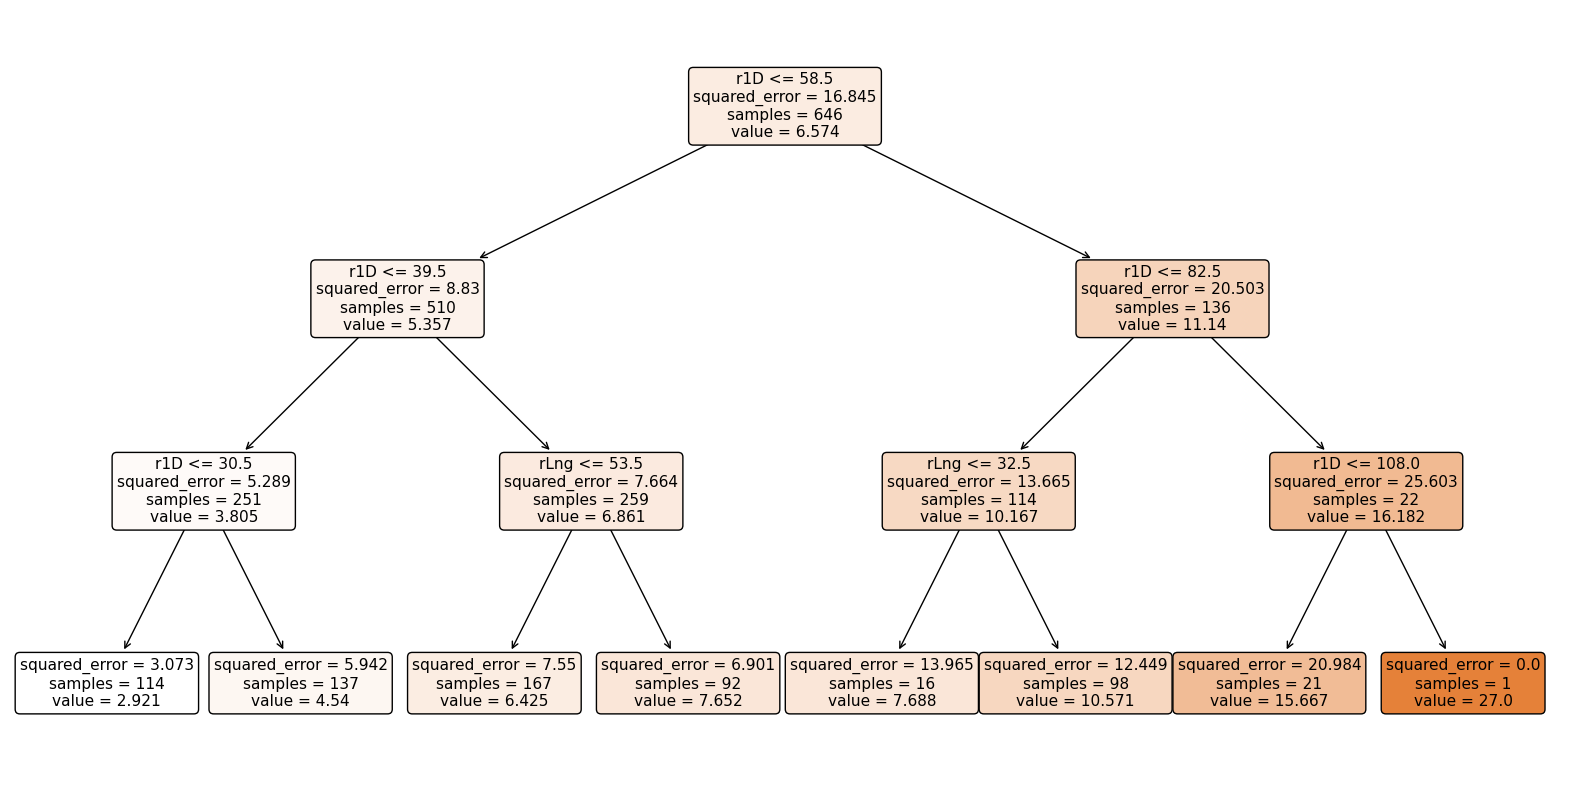

Decision Tree Regressor
Mean Squared Error (MSE): 8.062610303799913
R-squared (R2): 0.4509495432863222


In [ ]:
#5.4.	Decision Tree for regression (TASK 2)

#5.4.1. Selecting a subset of the features
X = rushingData[['rAtt', 'r1D', 'rYds', 'rLng', 'Age']]
#X = sm.add_constant(X)  # Adds a constant column to input features to account for the intercept
y = rushingData['rTD']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating a Decision Tree Regressor
regressor = DecisionTreeRegressor(max_depth=3, random_state=42)

# Training the model
regressor.fit(X_train, y_train)
feature_names = ['rAtt', 'r1D', 'rYds', 'rLng', 'Age']

# Plotting the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(regressor, filled=True, feature_names=feature_names, rounded=True)
plt.show()

# Predicting the rushing touchdowns in the test set
y_pred = regressor.predict(X_test)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
# R-squared Value
r2 = r2_score(y_test, y_pred)

# Displaying the statistics
print(f"Decision Tree Regressor")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Analysis

This model overall didnt do great with my dataset. The MSE was only 8 but this is high when prediciting rushing touchdowns. The R^2 was also quite low with only 0.45. So the model was able to capture 45% of the variability but still needs massive improvement.

In [ ]:
# Select predictor variables (x) and target variable (y)
X = rushingData[['rAtt', 'r1D', 'rYds', 'rLng', 'Age']]
#X = sm.add_constant(X)  # Adds a constant column to input features to account for the intercept
y = rushingData['rTD']

# Split the dataset into training and testing sets for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#6 Evaluating Model
#6.1.1.	Linear Regression using Lasso Regularization with crossvalidation. (TASK 1)

# Standardizing the features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Standardizing the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()  # Reshape for a single feature

# Creating and training a Lasso regression model with cross-validation to find the best alpha
lasso_cv = LassoCV(alphas=np.logspace(-6, 1, 10), cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train_scaled)

# Predicting rushing touchdowns using the trained Lasso regression model
y_pred_scaled = lasso_cv.predict(X_test_scaled)

# Reversing the scaling of predictions to the original scale
y_pred_lasso = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluating the model's performance
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Displaying the model statistics
print("Lasso Regression Model with Cross-Validation")
print(f"Chosen Alpha: {lasso_cv.alpha_}")
print(f"Coefficients: {lasso_cv.coef_}")
print(f"Intercept: {lasso_cv.intercept_}")
print(f"Mean Squared Error (MSE): {mse_lasso}")
print(f"R-squared (R2): {r2_lasso}")

Lasso Regression Model with Cross-Validation
Chosen Alpha: 0.007742636826811269
Coefficients: [-0.          0.7783154  -0.12582266  0.11651128  0.        ]
Intercept: 8.072779157502053e-17
Mean Squared Error (MSE): 7.014459017106406
R-squared (R2): 0.5364641349646333


In [ ]:
# 6.1.3. Multiple Logistic Regression model cross-validation - TASK 2

# a) Selecting a subset of the features and creating a binary category
X = rushingData[['rAtt', 'r1D', 'rYds', 'rLng', 'Age']]
X = sm.add_constant(X)  # Adds a constant column to input features to account for the intercept
y = rushingData['Fumble pred']

# b) Define a 5-fold cross-validation strategy
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# c) Initialize list to store cross-validation results
accuracies = []

# d) Perform k-fold cross-validation
for train_idx, test_idx in cv.split(X):
    # Split the data into training and test sets for this fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fit the model
    model = Logit(y_train, X_train).fit(disp=0)

    # Predict probabilities
    y_pred_prob = model.predict(X_test)

    # Convert probabilities to binary predictions
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Fold Accuracy: {accuracy:.4f}")

# e) Calculate the mean accuracy and standard deviation across all folds
mean_accuracy = np.mean(accuracies)
std_deviation = np.std(accuracies)

# f) Output the mean accuracy and standard deviation
print(f"\nMean Cross-validation Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation Between Folds: {std_deviation:.4f}")

Fold Accuracy: 0.7568
Fold Accuracy: 0.7405
Fold Accuracy: 0.6865
Fold Accuracy: 0.7568
Fold Accuracy: 0.6685

Mean Cross-validation Accuracy: 0.7218
Standard Deviation Between Folds: 0.0371


# Analysis

**Task 1:** For my first task task I evaluated it with Linear Regression using Lasso Regularization with crossvalidation. The mean squared error for this was fairly high at 7. The R^2 was also low at only 53%. The Rushing First Downs, Rushing Long, and Age however correlated well with predicting rushing touchdowns.

**Task 2:** For my second task I evaluated it using Multiple Logistic Regression model cross-validation. This model actually preformed well. The mean accuracy was good with 72%. Each fold also had a high accuracy. The standard deviation was also low which is reflected in the fold accuracy.

In [ ]:
#Step 7. DEPLOYMENT PHASE
#7.1. Make predictions and classifications with new data
# Random Forest Classifier - TASK 1

#7.1.1. Manually building df_new based on the sampled data

# Select 5 random points for each variable in your dataset
random_points = pd.DataFrame({
    'rAtt': np.random.uniform(rushingData['rAtt'].min(), rushingData['rAtt'].max(), size=5),
    'r1D': np.random.uniform(rushingData['r1D'].min(), rushingData['r1D'].max(), size=5),
    'rYds': np.random.uniform(rushingData['rYds'].min(), rushingData['rYds'].max(), size=5),
    'rLng': np.random.uniform(rushingData['rLng'].min(), rushingData['rLng'].max(), size=5),
    'Age': np.random.uniform(rushingData['Age'].min(), rushingData['Age'].max(), size=5)
})


random_predictions = clf.predict(random_points)

# Print predictions
print(f"{'Index':<6} {'Task 1':<15}")
for index, prediction in enumerate(random_predictions):
    print(f"{index:<6}{prediction:<15}")

Index  Task 1         
0     0              
1     0              
2     0              
3     1              
4     0              


In [ ]:
#5.4.	Decision Tree for regression (TASK 2)

random_points = pd.DataFrame({
    'rAtt': np.random.uniform(rushingData['rAtt'].min(), rushingData['rAtt'].max(), size=5),
    'r1D': np.random.uniform(rushingData['r1D'].min(), rushingData['r1D'].max(), size=5),
    'rYds': np.random.uniform(rushingData['rYds'].min(), rushingData['rYds'].max(), size=5),
    'rLng': np.random.uniform(rushingData['rLng'].min(), rushingData['rLng'].max(), size=5),
    'Age': np.random.uniform(rushingData['Age'].min(), rushingData['Age'].max(), size=5)
})

y_pred_random = regressor.predict(random_points)

# Print predictions for the new random data points
for index, prediction in enumerate(y_pred_random):
    print(f"Index {index + 1}: {prediction:.2f}")

Index 1: 15.67
Index 2: 2.92
Index 3: 15.67
Index 4: 2.92
Index 5: 15.67
